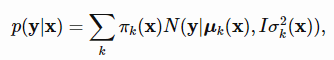

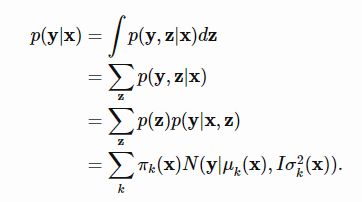

Likelihood with Model Parameter w 
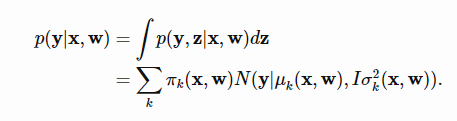

From Bayes' Theorem 
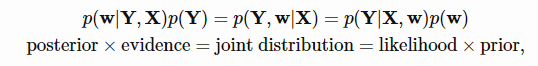
which leads to 
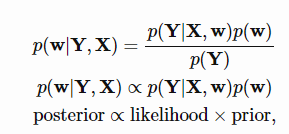

Now we realize that the evidence p(Y) is not a function of **w**. 
So we aim to maximize the posterior wrt **w** and define our Loss function **L(w)** in terms of likelihood and prior as 

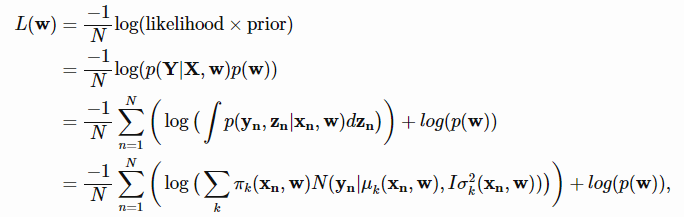

where we have used a logarithm to convert a product of probabilities into a summation of log probabilities for numerical stability, negation to allow for minimization instead of maximization, and averaged the summation to make the function invariant to batch sizes. We can now optimize our model parameters **w** by directly minimizing **L(w)** w.r.t. **w**. In the following code, we will assume a non-informative prior of p(w)= 1, which thus simplifies our loss function to:

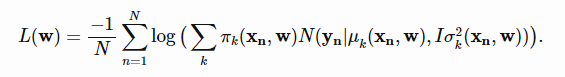

In [19]:
import math 
import matplotlib.pyplot as plt
import numpy as np 
import torch 
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim


n = 2500
d = 1
t = 1
h = 50
k = 30
d_pi = k
d_sigmasq = k
d_mu = t * k

In [20]:
w1 = Variable(torch.randn(d, h) * np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)

w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)

w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)

w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)

In [21]:
def forward(x):
  out = F.tanh(x.mm(w1) + b1)  # shape (n, h)
  pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)  # p(z_k = 1) for all k; K mixing components that sum to 1; shape (n, k)
  sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)  # K gaussian variances, which must be >= 0; shape (n, k)
  mu = out.mm(w_mu) + b_mu  # K * L gaussian means; shape (n, k*t)
  return pi, sigmasq, mu

In [22]:
def gaussian_pdf(x, mu, sigmasq):
  # NOTE: we could use the new `torch.distributions` package for this now
  return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)

In [23]:
def loss_fn(pi, sigmasq, mu, target):
  # compute the likelihood p(y|x) by marginalizing p(z)p(y|x,z)
  # over z. for now, we assume the prior p(w) is equal to 1,
  # although we could also include it here.  to implement this,
  # we average over all examples of the negative log of the sum
  # over all K mixtures of p(z)p(y|x,z), assuming Gaussian
  # distributions.  here, p(z) is the prior over z, and p(y|x,z)
  # is the likelihood conditioned on z and x.
  losses = Variable(torch.zeros(n))  # p(y|x)
  for i in range(k):  # marginalize over z  .......k is 30
    likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
    prior_z = pi[:, i]
    losses += prior_z * likelihood_z_x
  loss = torch.mean(-torch.log(losses))
  return loss

In [24]:
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

In [25]:
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise

x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)


x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(3000):
  opt.zero_grad()
  pi, sigmasq, mu = forward(x)
  loss = loss_fn(pi, sigmasq, mu, y)
  if e % 100 == 0:
    print(e, loss.item())
  loss.backward()
  opt.step()

0 1.0712007284164429
100 -0.603661060333252
200 -0.820274293422699
300 -0.9754185676574707
400 -1.0012052059173584
500 -0.9998441338539124
600 -1.0170445442199707
700 -1.0390403270721436
800 -1.0189520120620728
900 -1.0002702474594116
1000 -0.9330955147743225
1100 -0.968636155128479
1200 -1.0259727239608765
1300 -1.0282381772994995
1400 -1.02984619140625
1500 -1.0009465217590332
1600 -1.0308754444122314
1700 -0.7494408488273621
1800 -1.0362449884414673
1900 -1.0386971235275269
2000 -1.0007179975509644
2100 -1.0428826808929443
2200 -1.0448657274246216
2300 -0.9974150657653809
2400 -1.0462536811828613
2500 -1.0466538667678833
2600 -1.049689531326294
2700 -1.0327339172363281
2800 -1.0491524934768677
2900 -1.052687168121338


In [26]:
def sample_mode(pi, sigmasq, mu):
  # for prediction, could use conditional mode, but it doesn't
  # have an analytical solution (PRML p. 277). alternative is
  # to return the mean vector of the most probable component,
  # which is the approximate conditional mode from the mixture
  # NOTE: this breaks autograd, but that's fine because we
  # won't be computing gradients for this path
  # NOTE: pi, sigmasq, & mu are tensors
  n, k = pi.shape
  _, kt = mu.shape
  t = int(kt / k)
  _, max_component = torch.max(pi, 1)  # mixture w/ largest prob, i.e., argmax_k p(z==1)
  out = Variable(torch.zeros(n, t))
  for i in range(n):
    for j in range(t):
      out[i, j] = mu[i, max_component.data[i]*t+j]
  return out

In [27]:
def sample_preds(pi, sigmasq, mu, samples=10):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

In [28]:
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
preds = sample_preds(pi, sigmasq, mu, samples=10)

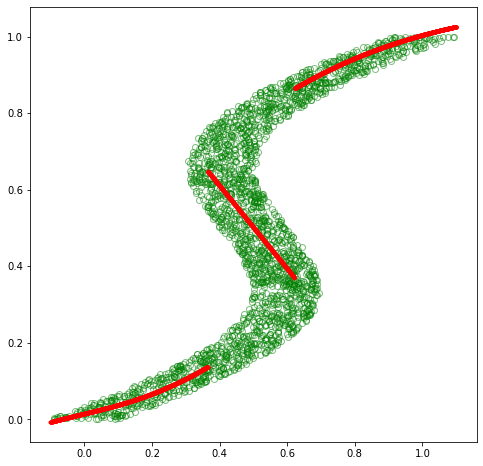

In [29]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, cond_mode.data.numpy(), 'r.')
plt.show()

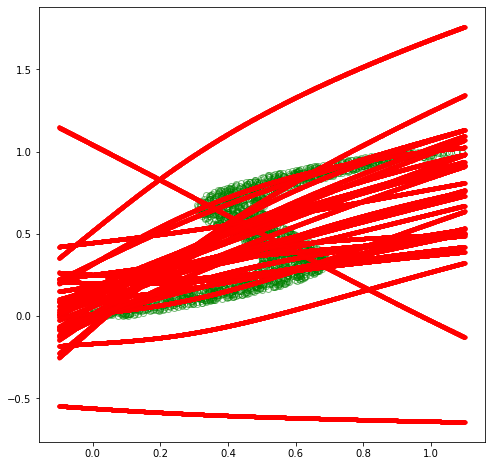

In [30]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, mu.data.numpy(), 'r.')
plt.show()

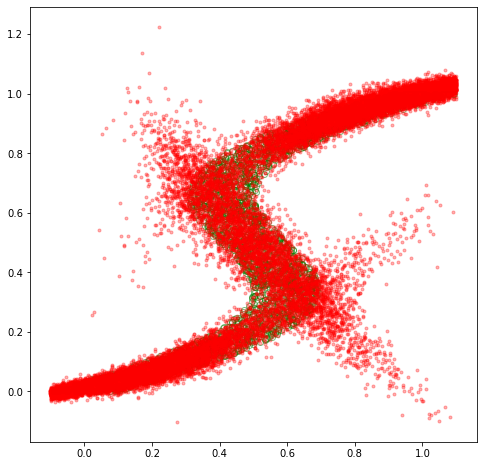

In [31]:
fig = plt.figure(figsize=(8,8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
  plt.plot(x_test, preds.data.numpy()[:, i].reshape(n, 1), 'r.', alpha=0.3)
plt.show()